<a href="https://colab.research.google.com/github/AyaTareekAhmmeed/project/blob/main/eye_disease_better.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip -uq "/content/drive/MyDrive/archive (1).zip" -d "/content/drive/My Drive/PATH_TO_OUTPUT"

In [2]:
#importing libraries 
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [3]:
# Add an additional column, mapping to the type
df = pd.read_csv('/content/drive/MyDrive/PATH_TO_OUTPUT/train.csv')

#binary to set data into Rd and non RD 
diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

#normal diagnosis to all stage/types of disease 
diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


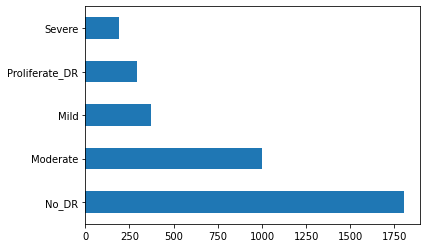

In [4]:
df['type'].value_counts().plot(kind='barh')

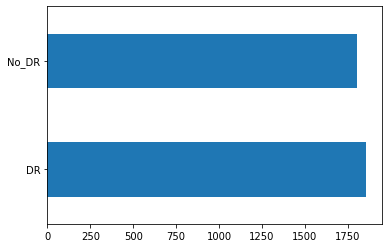

In [5]:
df['binary_type'].value_counts().plot(kind='barh')

In [6]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [7]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [8]:
# Copy images to respective working directory
src_dir = '/content/drive/MyDrive/PATH_TO_OUTPUT/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [9]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [29]:
# creating a CNN with an inception module
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import concatenate #for inception 
from keras.utils import plot_model

model = tf.keras.Sequential([
    layers.Conv2D(8, (1,1), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.Conv2D(8, (1,1), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    #layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (1,1), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (1,1), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.Conv2D(32, (5,5), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])
# summarize model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 224, 224, 8)       32        
                                                                 
 conv2d_22 (Conv2D)          (None, 224, 224, 8)       72        
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 112, 8)      0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 112, 112, 8)      32        
 hNormalization)                                                 
                                                                 
 conv2d_23 (Conv2D)          (None, 112, 112, 16)      144       
                                                                 
 conv2d_24 (Conv2D)          (None, 110, 110, 16)     

In [30]:
#batch_size = 128 #split training data into n batches for higher performance 
num_classes = 10 #num of classes on dataset 'based on dataset'
epochs = 12 #one forward%backward pass of all training examples

model.compile(optimizer='adam',
              loss= keras.losses.categorical_crossentropy,
              metrics = ['accuracy']
              )

model.fit(train_batches,
          epochs=epochs,
          verbose=1,
          validation_data=val_batches)

Epoch 1/12
81/81 [==============================] - 9s 100ms/step - loss: 0.6335 - accuracy: 0.8513 - val_loss: 0.8874 - val_accuracy: 0.5073
Epoch 2/12
81/81 [==============================] - 8s 95ms/step - loss: 0.2256 - accuracy: 0.9153 - val_loss: 0.7181 - val_accuracy: 0.5073
Epoch 3/12
81/81 [==============================] - 8s 95ms/step - loss: 0.1844 - accuracy: 0.9305 - val_loss: 0.7029 - val_accuracy: 0.5073
Epoch 4/12
81/81 [==============================] - 8s 93ms/step - loss: 0.1730 - accuracy: 0.9399 - val_loss: 1.1542 - val_accuracy: 0.4927
Epoch 5/12
81/81 [==============================] - 8s 94ms/step - loss: 0.1885 - accuracy: 0.9407 - val_loss: 0.9685 - val_accuracy: 0.4927
Epoch 6/12
81/81 [==============================] - 8s 94ms/step - loss: 0.1169 - accuracy: 0.9547 - val_loss: 0.7142 - val_accuracy: 0.6982
Epoch 7/12
81/81 [==============================] - 8s 94ms/step - loss: 0.0981 - accuracy: 0.9696 - val_loss: 0.2517 - val_accuracy: 0.9000
Epoch 8/12
8

In [31]:
#saving model to reuse its weights
model.save("modelh5.h5")
print('saved')

saved


In [32]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)

<ipython-input-32-b08fd55361be>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 1s 71ms/step - loss: 0.1735 - accuracy: 0.9582
Loss:  0.17351561784744263
Accuracy:  0.9581817984580994
